# DL Indaba Practical 2
# Feedforward Neural Networks on Real Data & Best Practices
*Developed by Stephan Gouws, Avishkar Bhoopchand & Ulrich Paquet.*

**Introduction**

In this practical we will move on and discuss best practices for building and training models on real world data (the famous MNIST dataset of hand-written images of digits). We will develop a deep, fully-connected ("feed-forward") neural network model that can classify these images with around 98% accuracy (close to state-of-the-art for feedforward models on this dataset). 

**Learning objectives**:

Understanding the issues involved in implementing and applying deep neural networks in practice (w/ a focus on TensorFlow). In particular:

* Implementation sanity checking details & controlled overfitting on a small training set.
 
* Training deep neural networks. Understand:
 * Conceptually how the backprop algorithm efficiently computes model gradients by applying the chain rule and applying dynamic programming (saving intermediate computations).
 * Overfitting and how to use regularization to avoid it (Weight decay/L2 and dropout).
 * Knowing when to stop training (early stopping).
 
* Understand the need for hyperparameter tuning in finding good architectures and training settings. 

**What is expected of you:**

* We have included rough time estimates of how long you should aim to spend on the important sections below.
* Step through the notebook answering the questions by discussing them with your lab partner. 
* Execute each cell in turn & fill in the missing code by pair-programming with your lab partner. 
* 5 min before the end, pair up with someone else and make sure you both understand the concepts listed in "Learning Objectives" above. If not, please speak to the tutors!

# Setups and Imports

For this practical, we will work with the [famous MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/). The task is to classify which digit a particular image represents. Luckily, since MNIST is a very popular dataset, TensorFlow has some built-in functions to download it. 

The MNIST dataset consists of pairs of images (28x28 matrices) and labels. Each label
is represented as a (sparse) binary    vector of length 10 with a 1 in position    `i` iff the image represents digit `i`, and 0 elsewhere. This is what the "one_hot" parameter you see below does. 

In [3]:
# Import TensorFlow and some other libraries we'll be using.
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Download the MNIST dataset onto the local machine.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# Visualizing the MNIST data

Let's visualize a few of the digits (from the training set): 

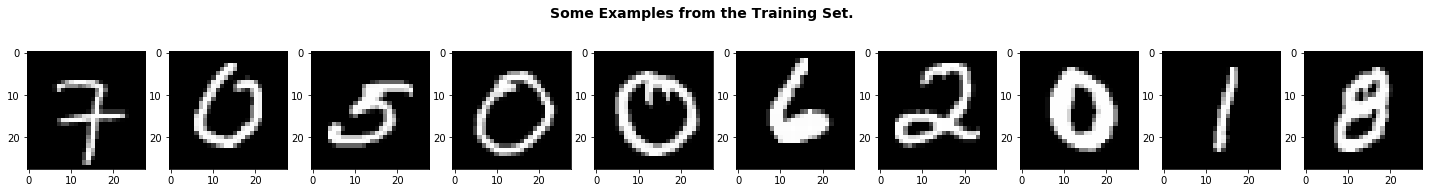

In [4]:
from matplotlib import pyplot as plt

plt.ioff()
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Helper plotting routine.
def display_images(gens, title=""):
    fig, axs = plt.subplots(1, 10, figsize=(25, 3))
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    for i in range(10):
        reshaped_img = (gens[i].reshape(28, 28) * 255).astype(np.uint8)
        axs.flat[i].imshow(reshaped_img)
        # axs.flat[i].axis('off')        
    return fig, axs


batch_xs, batch_ys = mnist.train.next_batch(10)
list_of_images = np.split(batch_xs, 10)
_ = display_images(list_of_images, "Some Examples from the Training Set.")
plt.show()

# Building a Feed-Forward Neural Network

In this section, we will build a neural network that takes the raw MNIST pixels as inputs and outputs 10 values, which we will interpret as the probability that the input image belongs to one of the 10 digit classes (0 through 9). Along the way, the data will pass through the hidden layers and activation functions we encountered in the first practical. 

**NOTE**: Standard feedforward neural network architectures can be summarised by chaining together the number of neurons in each layer, e.g. "784-500-300-10" would be a net with 784 input neurons, followed by a layer with 500 neurons, then 300, and finally 10 output classes. 

## Build the model (30min)

We want to explore the different choices and some of the best practices of training feedforward neural networks on the MNIST dataset. In this practical we will only be using "fully connected" (also referred to as "FC", "affine", or "dense") layers (i.e. no convolutional layers). So let's first write a little helper function to construct these:

In [5]:
def _dense_linear_layer(inputs, layer_name, input_size, output_size):
    """
    Builds a layer that takes a batch of inputs of size `input_size` and returns 
    a batch of outputs of size `output_size`.
         
    Args:
        inputs: A `Tensor` of shape [batch_size, input_size].
        layer_name: A string representing the name of the layer.
        input_size: The size of the inputs
        output_size: The size of the outputs
        
    Returns:
        out, weights: tuple of layer outputs and weights.
        
    """
    # Name scopes allow us to logically group together related variables.
    # Setting reuse=False avoids accidental reuse of variables between different runs.
    with tf.variable_scope(layer_name, reuse=False):
        # Create the weights for the layer
        layer_weights = tf.get_variable("weights",
                                        shape=[input_size, output_size], 
                                        dtype=tf.float32, 
                                        initializer=tf.random_normal_initializer())
        # Create the biases for the layer
        layer_bias = tf.get_variable("biases", 
                                     shape=[output_size], 
                                     dtype=tf.float32, 
                                     initializer=tf.random_normal_initializer())
        
        ## IMPLEMENT-ME: (1) 
                            #.      [1 * 784] [784 x 10]
        outputs = tf.add(tf.matmul(inputs, layer_weights), layer_bias)
    
    return outputs, layer_weights


Now let's use this to construct a linear softmax classifier as before, which we will expand into a near state-of-the-art feed-forward model for MNIST. We first create an abstract `BaseSoftmaxClassifier` base class that houses common functionality between the models. Each specific model will then provide a `build_model` method that represents the logic of that specific model.

In [6]:
class BaseSoftmaxClassifier:
    def __init__(self, input_size, output_size, l2_lambda):        
        # Define the input placeholders. The "None" dimension means that the 
        # placeholder can take any number of images as the batch size. 
        self.x = tf.placeholder(tf.float32, [None, input_size])
        self.y = tf.placeholder(tf.float32, [None, output_size])    
        self.input_size = input_size
        self.output_size = output_size
        self.l2_lambda = l2_lambda

        self._all_weights = [] # Used to compute L2 regularization in compute_loss().
        
        # You should override these in your build_model() function.
        self.logits = None
        self.predictions = None
        self.loss = None
        
        self.build_model()
        
    def get_logits(self):
        return self.logits
    
    def build_model(self):
        # OVERRIDE THIS FOR YOUR PARTICULAR MODEL.
        raise NotImplementedError("Subclasses should implement this function!")
        
    def compute_loss(self):
        """All models share the same softmax cross-entropy loss."""
        assert self.logits is not None    # Ensure that logits has been created! 
        
        # IMPLEMENT-ME: (2)
        # HINT: This time, use the TensorFlow function tf.nn.softmax_cross_entropy_with_logits  rather than 
        # implementing it manually like we did in Prac1
        data_loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y))

        reg_loss = 0.
        for w in self._all_weights:
            # IMPLEMENT-ME: (3)
            # HINT: TensorFlow has a built-in function for this too! tf.nn.l2_loss
            reg_loss += tf.nn.l2_loss(w)
            
        return data_loss + self.l2_lambda * reg_loss
    
    def accuracy(self):
        # Calculate accuracy.
        assert self.predictions is not None    # Ensure that pred has been created!
        
        # IMPLEMENT-ME: (4)
        # HINT: Look up the tf.equal and tf.argmax functions
        correct_prediction = tf.equal(tf.argmax(self.predictions, 1), tf.argmax(self.y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        return accuracy

If we wanted to reimplement the linear softmax classifier from before, we just need to override `build_model()` to perform one projection from the input to the output logits, like this:

In [7]:
class LinearSoftmaxClassifier(BaseSoftmaxClassifier):
    def __init__(self, intput_size, output_size, l2_lambda):
        super().__init__(input_size, output_size, l2_lambda)
        
    def build_model(self):
        # The model takes x as input and produces output_size outputs.
        self.logits, weights = _dense_linear_layer(
                self.x, "linear_layer", self.input_size, self.output_size)
        
        self._all_weights.append(weights)
        
        self.predictions = tf.nn.softmax(self.logits)
        
        self.loss = self.compute_loss()


In order to build a ***deeper*** model, let's add several layers with multiple transformations and rectied linear units (relus):

```python
def build_model(self):
     # The first layer takes x as input and has n_hidden_1 outputs.
     layer1, weights1 = _build_linear_layer(self.x, "layer1", self.input_size, self.num_hidden_1)
     self._all_weights.append(weights1)
     layer1 = tf.nn.relu(layer1)
        
     # The second layer takes layer1's output as its input and has num_hidden_2 outputs.
     layer2, weights2 = _build_linear_layer(layer1, "layer2", self.num_hidden_1, self.num_hidden_2)
     self._all_weights.append(weights2)
     layer2 = tf.nn.relu(layer2)
     
     # The final layer is our predictions and goes from num_hidden_2 inputs to 
     # num_classes outputs. The outputs are "logits" (un-normalised scores). 
     self.logits, weights3 = _build_linear_layer(layer2, "output", self.num_hidden_2, self.output_size)
     self._all_weights.append(weights3)
     
     self.pred = tf.nn.softmax(self.logits)
     self.loss = self.compute_loss(self.logits, self.y)
 ```

**Note: Instead of writing special classes for linear nets (0 hidden layers), 1 hidden layer nets, 2 hidden layer nets, etc., we can generalize this as follows:**

In [8]:
class DNNClassifier(BaseSoftmaxClassifier):
    """DNN = Deep Neural Network - now we're doing Deep Learning! :)"""
    
    def __init__(self, 
                 input_size=784,    # There are 28x28 = 784 pixels in MNIST images
                 hidden_sizes=[],    # List of hidden layer dimensions, empty for linear model.
                 output_size=10,    # There are 10 possible digit classes
                 act_fn=tf.nn.relu,    # The activation function to use in the hidden layers
                 l2_lambda=0.):    # The strength of regularisation, off by default.
        
        self.hidden_sizes = hidden_sizes
        self.act_fn = act_fn
        super().__init__(input_size, output_size, l2_lambda)
        
        
    def build_model(self):
        prev_layer = self.x
        prev_size = self.input_size
        
        for layer_num, size in enumerate(self.hidden_sizes):        
            layer_name = "layer_" + str(layer_num)
            ## IMPLEMENT-ME: (5)
            # HINT: Use the linear function we defined earlier!
            layer, weights = _dense_linear_layer(prev_layer, layer_name, prev_size, size)

            self._all_weights.append(weights)
            ## IMPLEMENT-ME: (6)
            # HINT: What do we still need to do after doing the "linear" part? 
            layer = self.act_fn(layer)
            prev_layer, prev_size = layer, size

        # The final layer is our predictions and goes from prev_size inputs to 
        # output_size outputs. The outputs are "logits", un-normalised scores. 
        self.logits, out_weights = _dense_linear_layer(prev_layer, "output", prev_size, self.output_size)
        self._all_weights.append(out_weights)
        
        self.predictions = tf.nn.softmax(self.logits)
        self.loss = self.compute_loss()
    

We can now create a linear model, i.e. a 784-10 architecture (note that there is only one possible linear model going from 784 inputs to 10 outputs), as follows:

```python
    tf_linear_model = DNNClassifier(input_size=784, hidden_sizes=[], output_size=10)
```

We can create a deep neural network (DNN, also called a "multi-layer perceptron") model, e.g. a 784-512-10 architecture (there can be many others...), as follows:

```python
    tf_784_512_10_model = DNNClassifier(input_size=784, hidden_sizes=[512], output_size=10)
```

and so forth.

**NOTE: Make sure you understand how this works before you move on.**

## Sanity Checks (5-10 min)

### Dealing with randomness

Pseudo-random number generators start from some value (the 'seed') and generate numbers which appear to be random. It is good practise to seed RNGs with a fixed value to encourage reproducibility of results. We do this in NumPy by using `np.random.seed(1234)`, where `1234` is your chosen seed value. 

In TensorFlow we can set a *graph-level* seed (global, using `tf.set_random_seed(1234)`) or an *op-level* seed (passed in to each op via the `seed` argument, to override the graph-level seed.)

Next we need to initialize the parameters of our model. We do *not* want to initialize all weights to be the same. 

**QUESTION**: Can you think of why this might be a bad idea? (Think about a simple MLP with one input and 2 hidden units and one output. Look at the contributions via each weight connection to the activations on the hidden layer. Now let those weights be equal. How does that affect the contributions? How does that affect the update that backprop would propose for each weight? Do you see any problems?)

The simplest approach is to **initialize weights (W's) to small random values**. For ReLUs specifically, it is recommended to initialize weights to `np.random.randn(n) * sqrt(2.0/n)`, where `n` is the number of inputs to that layer (neuron on the previous layer) (see [He et al., 2015](https://arxiv.org/pdf/1502.01852.pdf) for more information). This initialization encourages the distributions over ReLU activations to have roughly the same variance at each layer, which in turn ensures that useful gradient information gets sent back during backpropagation.

Biases are not that sensitive to initialization and can be initialized to 0s or small random numbers.

### Check the loss of a random model

When we have a new model, it's always a good idea to do a quick sanity check. A random model that predicts C classes on random data should have no reason for preferring either class, i.e., on average its loss (negative log-likelihood) should be $-\log(1/C) = -\log(C^{-1}) = \log(C)$. 

**NOTE**: TF actually computes the cross-entropy on the *logits* for numerical stability reasons (logs of small numbers blow up quickly..). This means we'll get a different value from `tf.nn.softmax_cross_entropy_with_logits`. So for this check we will just manually compute the cross-entropy (negative log-likelihood).

The second thing to check is that adding the L2 loss (a strictly positive value), should *increase* total loss (here we'll just use the TF cross-entropy as provided).

In [9]:
tf.set_random_seed(1234)
np.random.seed(1234)

# Generate a batch of 100 "images" of 784 pixels consisting of Gaussian noise.
x_rnd = np.random.randn(100, 784)
print("Sample of random data:\n", x_rnd[:5,:])    # Print the first 5 "images"
print("Shape: ", x_rnd.shape)
# Generate some random one-hot labels.
y_rnd = np.eye(10)[np.random.choice(10, 100)]
print("Sample of random labels:\n", y_rnd[:5,:])
print("Shape: ", y_rnd.shape)

# Model without regularization.
tf.reset_default_graph()
tf_linear_model = DNNClassifier(l2_lambda=0.0)
x, y = tf_linear_model.x, tf_linear_model.y

with tf.Session() as sess:
    # Initialize variables.
    init = tf.global_variables_initializer()
    sess.run(init)
    
    avg_cross_entropy = -tf.log(tf.reduce_mean(tf_linear_model.predictions))
    loss_no_reg = tf_linear_model.loss
 
    manual_avg_xent, loss_no_reg = sess.run([avg_cross_entropy, loss_no_reg],
                                            feed_dict={x : x_rnd, y: y_rnd})
    
    
# Sanity check: Loss should be about log(10) = 2.3026
print('\nSanity check manual avg cross entropy: ', manual_avg_xent)
print('Model loss (no reg): ', loss_no_reg)

# Model with regularization.
tf.reset_default_graph()
tf_linear_model = DNNClassifier(l2_lambda=1.0)
x, y = tf_linear_model.x, tf_linear_model.y

with tf.Session() as sess:
    # Initialize variables.
    init = tf.global_variables_initializer()
    sess.run(init)
    loss_w_reg = tf_linear_model.loss.eval(feed_dict={x : x_rnd, y: y_rnd})

# Sanity check: Loss should go up when you add regularization
print('Sanity check loss (with regularization, should be higher): ', loss_w_reg)

Sample of random data:
 [[ 0.47143516 -1.19097569  1.43270697 ... -0.2453605  -1.26943186
  -0.26232386]
 [ 2.33759848 -0.78171744  0.08009975 ... -0.64055353  1.76256841
  -0.08567302]
 [ 1.63617833 -0.54410827 -1.04999868 ... -0.90640906  0.31915076
  -0.49914386]
 [-0.66039926  0.0774697   0.38755182 ...  0.31019053  1.87791254
  -0.70183467]
 [-3.23350453  0.20024296 -0.13933709 ... -0.72622006  0.50774695
   0.18987136]]
Shape:  (100, 784)
Sample of random labels:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Shape:  (100, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.


Sanity check manual avg cross entropy:  2.3025851
Model loss (no reg):  46.757496
Sanity check loss (with regularization, should be higher):  3836.2979

## Compute the gradients: Backpropagation Review

Once one has implemented the model and checked that the loss produces sensible outputs it is time to create the training loop. For this, we will need to obtain the gradients of the loss wrt each model parameter. We've already looked at this in detail in practical 1, where we performed this manually. One of the great benefits of using a library like TensorFlow, is that it can automatically derive the gradients wrt any parameter in the graph (using `tf.gradients()`).

In the previous practical we saw that there is a common pattern to deriving the gradients in neural networks:

1. propagate activations forward through the network ("make a prediction" $\Rightarrow$ `fprop`),
2. compute an error delta ("see how far we're off") , and
3. propagate errors backwards to update the weights ("update the weights to do better next time" $\Rightarrow$ `backprop`).

It turns out that for deeper networks, ***this pattern repeats for every new layer***. Take a deep breath, and let's dive in, starting with fprop:

### FPROP

Conceptually, forward propagation is very simple: Starting with the input `x`, we repeatedly apply an affine function and a non-linearity to arrive at the output $a^L = \sigma^L(W^{L-1}\sigma^{L-1}( \ldots \sigma(W^1x + b^1) \dots ) + b^{L-1})$. 

Mathematically, forward propagation comes down to a **composition of functions**. So for two layers, the output activation $a^2$ is the composition of the function $a^1 = f^1(x)$ and $a^2 = f^2(a^1)$ $\Rightarrow$ $a^2 = f^2(f^1(x))$.

**NOTE**: We save both the pre-activations (before the non-linearity) *and* the (post-)activations (after the nonlinearity). We'll need these for the backprop phase!

In code it looks like this:

In [10]:
# PSEUDOCODE:

def fprop(x, weights, biases, per_layer_nonlinearities):

    # Initialise the input. We pretend inputs are the first pre- and post-activations.
    z = a = x
    cache = [(z, a)] # We'll save z's and a's for the backprop phase.
    
    for W, b, act_fn in zip(weights, biases, per_layer_nonlinearities): 
        
        z = np.dot(W, a) + b        # "pre-activations" / logits
        a = act_fn(z)               # "outputs" / (post-)activations of the current layer
        
        # NOTE: We save both pre-activations and (post-)activations for the backwards phase!
        cache.append((z, a))
            
    return cache # Per-layer pre- and post-activations.

### BACKPROP

Given a loss or error function $E$ at the output (e.g. cross-entropy), we then need the derivative of the loss wrt each of the model parameters in order to train the network (decrease the loss). Mathematically, this comes down to the derivative of a composition of functions, and from calculus we know we have the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) for that: If $a = f(g(x))$, then $\frac{\partial a}{\partial x} = \frac{\partial f}{\partial g} \frac{\partial g}{\partial x}$.

In order to get the gradients on some intermediate parameter $\theta^i = \{W^i, b^i\}$ in layer $i$, we just apply the chain rule over all $L$ 'layers' of this composition of functions (the neural network) to derive the intermediate gradients:

\begin{aligned}
    \frac{\partial E}{\partial \theta^{(i)}} 
        &= \underbrace{ \frac{\partial E}{\partial z^{(L)}} \frac{\partial z^{(L)}}{\partial z^{(L-1)}} \ldots \frac{\partial z^{(i+2)}}{\partial z^{(i+1)}}}_{\triangleq \delta^{(i+1)}} \frac{\partial z^{(i+1)}}{\partial \theta^{(i)}} \\
    &= \delta^{(i+1)} \frac{\partial z^{(i+1)}}{\partial \theta^{(i)}}
\end{aligned}

We have glossed a little over the fact that we are dealing with matrices and vectors, for the sake of brevity. But please see these two great resources:
* For a step-by-step walk-through of the mechanics of backpropagation, see [this great resource](http://cs224d.stanford.edu/lecture_notes/notes3.pdf).
* For a great brush-up on the mechanics of vector calculus, see [this fantastic note](https://web.stanford.edu/class/cs224n/lecture_notes/cs224n-2017-gradient-notes.pdf) (for the same course).

**NOTE**: 
* $E$ is the error/loss function at the output.
* $W^{(i)}$ is an intermediate weight matrix mapping activations from layer $i$ to pre-activations $z^{(i+1)}$ at layer $i+1$.
* The derivative with respect to the *inputs* of layer $i$ are called deltas and is defined as $\delta^{(i)} \triangleq \frac{\partial E}{\partial z^{(i)}}$. 
    * $\delta^i$ is a vector (the size of the layer $i$), and is the result of the deltas at the output $\delta^L$ (dE/dlogits) multiplied by a product of [Jacobian matrices](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant). If you don't understand this statement, just think of $\delta^i_j$ as the contribution that unit $j$ in layer $i$ made to the total error $E$. Also, read up on this in the resources linked above.
    * **NB**: $z^{(i)}$ are the pre-activations ("logits" at the output layer)!
* $\frac{\partial z^{(i+1)}}{\partial W^{(i)}} = \frac{\partial (W^{(i)}a^i + b^i)}{\partial W^{(i)}} = a^i$. 
* Likewise, $\frac{\partial z^{(i+1)}}{\partial b^{(i)}} = 1$ (check this for yourself).


**QUESTIONS**: 
1. What is the shape of $\frac{\partial E}{\partial \mathbb{W}^{(i)}}$?
    * Convince yourself (now or later) that $\frac{\partial E}{\partial W^{(i)}_{jk}} = \delta^{(i+1)}_k {a^i_j}$ (a scalar), and therefore $\frac{\partial E}{\partial \mathbb{W}^{(i)}} = \mathbb{\delta}^{(i+1)} {\mathbb{a}^i}^T$ (outer product of two vectors, therefore a matrix of the same shape as $W^i$). 
    * **In words: The gradient on weights $W^i$ at layer $i$ is the outer product of the deltas-vector from the layer above $\delta^{(i+1)}$ and the activations vector from the layer below $a^i$.**

2. What is the shape of $\frac{\partial E}{\partial \mathbb{b}^{(i)}}$?
    * Convince yourself (now or later) that $\frac{\partial E}{\partial \mathbb{b}^{(i)}} = \mathbb{\delta}^{(i+1)}$ (a vector of the same length as $b^i$).
    * **In words: The gradient on biases $b^i$ at layer $i$ is equal to the deltas at the layer above**.
3. Make sure you understand why we save the `(z,a)`'s during fprop, and how we use them during backprop.


Note that we need to compute the deltas at every layer, and $\delta^i$ share all the terms of $\delta^{(i+1)}$ (which we've already computed), except one. Backprop has one more trick up its sleeve, and that is to *reuse previously computed values to save computation* (this is called [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming)). For the deltas, this comes down to computing $\delta^{(i)}$ given $\delta^{(i+1)}$. We won't show the full derivation (but we again use the chain rule, see the notes linked above) to arrive at:

\begin{align}
    \delta^{(i)} &= \frac{\partial E}{\partial z^{(i)}} \\
                             &= \ldots \\
                             &= \underbrace{ \left[ \delta^{(i+1)} {\mathbb{W}^{(i)}}^T \right] }_\textrm{Map the global delta 'backwards' through W up to layer $i$} \circ \underbrace{ \sigma'(z^{(i)}) }_\textrm{Correct for the local errors at this layer.}.
\end{align}

**In words: The delta on the current layer $i$ is the delta on the layer above $\delta^{(i+1)}$ multiplied by the transpose weights matrix between the two layers $W^i$ to yield a vector, scaled by the element-wise multiplication of $\sigma'(z^{(i)})$ (the derivative of the non-linearity applied to the original pre-activations).**

**QUESTIONs**: Look at the code below and make sure you understand (at least conceptually) how this works.

In [11]:
# PSEUDOCODE

def backprop(target, fprop_cache, weights):
    
    # Pop/remove the model prediction (last activation `a` we computed above) 
    # off the cache we created during the fprop phase.
    (_, pred) = fprop_cache.pop() 
    
    # Intialise delta^{L} (at the output layer) as dE/dz (cross-entropy).
    delta_above = (target - pred)         
    grads = []
    
    # Unroll backwards from the output:
    for (z_below, a_below), W_between in reversed(zip(fprop_cache, weights)):
        
        # Compute dE/dW:
        Wgrad = np.dot(delta_above, a_below.T) # Outer product
        
        # Compute dE/db:
        bgrad = delta_above     
        
        # Save these:
        grads.append((Wgrad, bgrad))
        
        # Update for the *next* iteration/layer. Note the elem-wise multiplication.
        # Note the use of z_below, the preactivations in the layer below!
        # delta^i = delta^{(i+1)}.(W^i)^T .* sigma'(z_i):
        delta_above = np.dot(delta_above, W_between.T) * dsigmoid(z_below)
    
    grads.reverse()
    return grads

Ppphhhhhheeeeewwwww, ok, come up for a breather. We know. This takes a while to wrap your head around. For now, just try to get the high-level picture! Depending on your background, this may well be the toughest part of the week. 

**BACKPROP SUMMARY NOTE**: It helps to have a good idea of what backprop does, and for this it helps to work through one example by hand (see the linked notes above). But you don't need to understand every detail above for the rest of this and the following lectures. The good news is that in practise you won't compute gradients by hand, and all of the above is done for us by `tf.gradients()` (or the similar function in other packages)!

**BACKPROP FINAL QUESTION**:    Take a few minutes to explain the high-level details of the backprop algorithm to your neighbour. Try to understand how fprop is essentially just a composition of functions applied to the input, and backprop 'peels off' those compositions one by one by following the chain rule. In the process it avoids recomputation by saving activations during fprop, and computing deltas during backprop. Be sure to ask the tutors if you're stuck!


In [12]:
"""
# PSEUDOCODE:

biases, weights = [b1, b2], [W1, W2]
x, y = ..., ...
non_linearities = [relu, softmax]

fprop_cache = fprop(x, weights, biases, non_linearities)
grads = backprop(y, fprop_cache, weights)
"""

'\n# PSEUDOCODE:\n\nbiases, weights = [b1, b2], [W1, W2]\nx, y = ..., ...\nnon_linearities = [relu, softmax]\n\nfprop_cache = fprop(x, weights, biases, non_linearities)\ngrads = backprop(y, fprop_cache, weights)\n'

## Training deep neural networks (10min)

Now that we have a model with a loss and gradients, let's write a function to train it! This will be largely similar to the `train_tf_model()` function (same name, see below) from the previous practical. However, we are introducing several new concepts in this practical:

* how to update parameters using different optimizers, 
* model complexity and how to match this to your data: 
    * recognizing overfitting 
    * adding regularization (L2, dropout)
* knowing when to stop training: early stopping,

As we go through these concepts, we will show how to use them in our training function.

### Optimizers

Training neural networks involves solving an optimization problem. **Stochastic gradient-based methods** are by far the most popular family of techniques that are being used for this. These methods evaluate the gradient of the loss on a small part of the data (called a **mini-batch**), and then propose a small change to the weights based on the current sample (and some maintain running averages over the previous steps), that reduces the loss, before moving on to another sample of the data:

```
step = optimizer(grad(cost), learning_rate, ...) 
new_weights = old_weights + step
```

The oldest algorithm is stochastic gradient descent, but there are many others (Adagrad, AdaDelta, RMSProp, ADAM, etc.). As a general rule of thumb, ADAM or SGD with Momentum tend to work quite well out of the box, but this depends on your model and your data! See these two great blog posts for more on this: 

* http://ruder.io/optimizing-gradient-descent/
* https://medium.com/towards-data-science/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f

In our code, we can select different optimization functions by passing in a different optimizer to `train_tf_model` (see the full list here: https://www.tensorflow.org/api_guides/python/train#Optimizers) as follows:

```python

optimizer = tf.train.RMSProp(...)
results_tuple = train_tf_model(optimizer_fn=optimizer, ...)
```

### Training / validation / test splits

When training supervised machine learning models, the goal is to build a model that will perform well on some test task with data that we'll obtain some time in the future. Unfortunately, until we solve time-travel, we don't yet have access to that data. So how do we train a model on data we have now, to perform well on some (unseen) data from the future? This, in a nutshell, is the statistical learning problem: we want to train a data on available data to **generalize** to unseen test data.

The way we approach this is to take a dataset that we do have, and split it into a **training**, **validation**, and **test set** (split). Typically we will use ratios of 80/10/10 for example. We then train our model on the training set only, and use the validation set to make all kinds of decisions about architectural selection, hyperparameters, etc. When we're done, we evaluate our model and report its accuracy on the **test set only**. 

**NOTE**: We (typically) do not train on the validation set, and we **never** train on the test set. Think about why training on the test set might be a bad thing?

### Model complexity, overfitting & regularization

**Overfitting** occurs when improving the model's training loss (its performance on training data) comes at the expense of its **generalisation ability** (its performance on unseen test data). Generally it is a symptom of the **model complexity** increasing to fit the peculiarities (outliers) of the training data too accurately, causing it not to generalize well to new unseen (test) data. Overfitting is usually indicated when:

* training & validation loss starts decreasing at different rates,
* validation error starts increasing while training error still goes down,
* training error reaches 0.

**Underfitting** is the opposite: when a model cannot fit the training data well enough (usually a sign to train for longer or add more parameters to the model).

You can think of complexity as how "wiggly" or "wrinkly" the decision boundary that the model can represent is. We can increase model complexity by adding more layers (i.e. more parameters). We can control or reduce the model complexity of an architecture using a family of techniques called **regularisers**. We've already encountered L2-regularisation (also called **weight-decay**), where we penalise the model for having very large weights. Another option is L1 regularization (which encourages sparsity of weights). Another very popular current technique is called **dropout** (we'll look at this in more detail in Practical 3). There are many others, but these two are the most popular.

We will only be using L2 regularization in this practical. It can be set by passing a non-zero value to `l2_lambda` when constructing a `DNNClassifier` instance.

### Early stopping

Neural networks are nonlinear models and can have very complicated optimization landscapes. Stochastic gradient based methods for optimizing these loss functions do not proceed monotonically (i.e. does not just keep going up). Sometimes the loss can go down for a while before it goes up to reach a better part of parameter space later. How do we know when to stop training?

**Early stopping** is one technique that helps with this. It is added to the training routine and means that we periodically evaluate the model's performance on the validation set (***Crucially! not the test set. Why?***). If the performance on the validation set starts becoming worse we know we have reached the point of overfitting (usually), so it usually makes sense to stop training and not waste any more computations. The `train_tf_model` function we build has an early-stopping feature that you can enable by passing the `stop_early=True` parameter. Have a look at the code to see how this is done. 

![early stopping](images/early_stopping.png "Diagram illustrating early stopping using validation results")

For this practical, we just implemented the most basic idea of early stopping: stop training as soon as the model starts doing worse on validation data. However, there are different ways of implementing this idea. Two of the most popular are 

* "early stopping with patience": don't stop training immediately once validation accuracy degrades, but wait for P more epochs, and reset P if the model starts improving again within this timeframe,
* training for T epochs, and simply selecting the best model based on validation score over the entire T epochs.

**QUESTION**: What are the pros and cons of these different methods?



## Wrapping these ideas into the training function (10-15min)

The training function below implements all the ideas we discussed above.

In [13]:
class MNISTFraction:
    """A helper class to extract only a fixed fraction of MNIST data."""
    def __init__(self, mnist, fraction):
        self.mnist = mnist
        self.num_images = int(mnist.num_examples * fraction)
        self.image_data, self.label_data = mnist.images[:self.num_images], mnist.labels[:self.num_images]
        self.start = 0
        
    def next_batch(self, batch_size):
        start = self.start
        end = min(start + batch_size, self.num_images)
        self.start = 0 if end == self.num_images else end
        
        return self.image_data[start:end], self.label_data[start:end]

In [14]:
def train_tf_model(tf_model,                                     
                   session,    # The active session.
                   num_epochs,    # Max epochs/iterations to train for.
                   batch_size=50,    # Number of examples per batch.
                   keep_prob=1.0,    # (1. - dropout) probability, none by default.
                   train_only_on_fraction=1.,    # Fraction of training data to use.
                   optimizer_fn=None,    # The optimizer we want to use
                   report_every=1, # Report training results every nr of epochs.
                   eval_every=1,    # Evaluate on validation data every nr of epochs.
                   stop_early=True,    # Use early stopping or not.
                   verbose=True): 

    # Get the (symbolic) model input, output, loss and accuracy.
    x, y = tf_model.x, tf_model.y
    loss = tf_model.loss
    accuracy = tf_model.accuracy()

    # Compute the gradient of the loss with respect to the model parameters 
    # and create an op that will perform one parameter update using the specific
    # optimizer's update rule in the direction of the gradients.
    if optimizer_fn is None:
        optimizer_fn = tf.train.AdamOptimizer()
    optimizer_step = optimizer_fn.minimize(loss)

    # Get the op which, when executed, will initialize the variables.
    init = tf.global_variables_initializer()
    # Actually initialize the variables (run the op).
    session.run(init)

    # Save the training loss and accuracies on training and validation data.
    train_costs = []
    train_accs = []
    val_costs = []
    val_accs = []

    if train_only_on_fraction < 1:
        mnist_train_data = MNISTFraction(mnist.train, train_only_on_fraction)
    else:
        mnist_train_data = mnist.train
    
    prev_c_eval = 1000000
    
    # Main training cycle.
    for epoch in range(num_epochs):

        avg_cost = 0.
        avg_acc = 0.
        total_batches = int(train_only_on_fraction * mnist.train.num_examples / batch_size)

        # Loop over all batches.
        for i in range(total_batches):
            batch_x, batch_y = mnist_train_data.next_batch(batch_size)
                        
            # Run optimization op (backprop) and cost op (to get loss value),
            # and compute the accuracy of the model.
            feed_dict = {x: batch_x, y: batch_y}
            if keep_prob < 1.:
                feed_dict["keep_prob:0"] = keep_prob
                
            _, c, a = session.run([optimizer_step, loss, accuracy], feed_dict=feed_dict)
                        
            # Compute average loss/accuracy
            avg_cost += c / total_batches
            avg_acc += a / total_batches            
        
        train_costs.append((epoch, avg_cost))
        train_accs.append((epoch, avg_acc))

        # Display logs per epoch step
        if epoch % report_every == 0 and verbose:
            print("Epoch:", '%04d' % (epoch+1), "Training cost=", "{:.9f}".format(avg_cost))
                
        if epoch % eval_every == 0:
            val_x, val_y = mnist.validation.images, mnist.validation.labels            
            
            feed_dict = {x : val_x, y : val_y}
            if keep_prob < 1.:
                feed_dict['keep_prob:0'] = 1.0
                
            c_eval, a_eval = session.run([loss, accuracy], feed_dict=feed_dict)
            
            if verbose:
                print("Epoch:", '%04d' % (epoch+1), "Validation acc=", "{:.9f}".format(a_eval))
                
            if c_eval >= prev_c_eval and stop_early:
                print("Validation loss stopped improving, stopping training early after %d epochs!" % (epoch + 1))
                break
                
            prev_c_eval = c_eval
                
            val_costs.append((epoch, c_eval))
            val_accs.append((epoch, a_eval))
            
    
    print("Optimization Finished!")
    return train_costs, train_accs, val_costs, val_accs

    

In [15]:
# Helper functions to plot training progress.

def my_plot(list_of_tuples):
    """Take a list of (epoch, value) and split these into lists of 
    epoch-only and value-only. Pass these to plot to make sure we
    line up the values at the correct time-steps.
    """
    plt.plot(*zip(*list_of_tuples))

def plot_multi(values_lst, labels_lst, y_label, x_label='epoch'):
    # Plot multiple curves.
    assert len(values_lst) == len(labels_lst)
    plt.subplot(2, 1, 2)
    
    for v in values_lst:
        my_plot(v)
    plt.legend(labels_lst, loc='upper left')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()    


## Wrapping everything together and verifying that it works (10min)

Once we have a training function, it is usually a good idea to train on a small amount of your data first to verify that everything is indeed working. We can put all the pieces together to achieve this as follows:

In [16]:
##### BUILD MODEL #####
tf.reset_default_graph()    # Clear the graph.
model = DNNClassifier()     # Choose model hyperparameters.

with tf.Session() as sess:

    ##### TRAIN MODEL #####

    train_losses, train_accs, val_losses, val_accs = train_tf_model(
            model,
            session=sess,
            num_epochs=10, 
            train_only_on_fraction=1e-1,
            optimizer_fn=tf.train.GradientDescentOptimizer(learning_rate=1e-3),
            report_every=1,
            eval_every=2,
            stop_early=False) 

    ##### EVALUATE MODEL ON TEST DATA #####

    # Get the op which calculates model accuracy.
    accuracy_op = model.accuracy()    # Get the symbolic accuracy operation
    
    # Connect the MNIST test images and labels to the model input/output
    # placeholders, and compute the accuracy given the trained parameters.
    accuracy = accuracy_op.eval(feed_dict = {model.x: mnist.test.images, 
                                             model.y: mnist.test.labels})
    
    print("Accuracy on test set:", accuracy)

Epoch: 0001 Training cost= 11.367639403
Epoch: 0001 Validation acc= 0.140200004
Epoch: 0002 Training cost= 10.970869580
Epoch: 0003 Training cost= 10.625609350
Epoch: 0003 Validation acc= 0.142600000
Epoch: 0004 Training cost= 10.321249723
Epoch: 0005 Training cost= 10.049566373
Epoch: 0005 Validation acc= 0.146400005
Epoch: 0006 Training cost= 9.804254710
Epoch: 0007 Training cost= 9.580430967
Epoch: 0007 Validation acc= 0.151999995
Epoch: 0008 Training cost= 9.374331479
Epoch: 0009 Training cost= 9.183043150
Epoch: 0009 Validation acc= 0.156599998
Epoch: 0010 Training cost= 9.004260596
Optimization Finished!
Accuracy on test set: 0.159


Instead of just training and checking that the loss goes down, it is usually a good idea to try to **overfit a small subset of your training data**. We will do this below by training a 1 hidden layer network on a subset of the MNIST training data, by setting the `train_only_on_fraction` training hyperparameter to 0.05 (i.e. 5%). We turn off early stopping for this. The following diagram illustrates the difference between under-fitting and over-fitting. Note that the diagram is idealised and it's not always this clear in practice!

![overfitting](images/over_and_under_fitting.png "Over and Under Fitting")

**QUESTION**: Why do we turn off early-stopping?

In the rest of this practical, we will explore the effects of different model hyperparameters and different training choices, so let's wrap everything together to emphasize these different choices, and then train a simple model for a few epochs on 5% of the data to verify that everything works and that we can overfit a small portion of the data.

Epoch: 0001 Training cost= 114.139924414
Epoch: 0001 Validation acc= 0.457199991
Epoch: 0002 Training cost= 39.938992899
Epoch: 0003 Training cost= 24.148555253
Epoch: 0003 Validation acc= 0.704800010
Epoch: 0004 Training cost= 16.921453953
Epoch: 0005 Training cost= 12.617178215
Epoch: 0005 Validation acc= 0.767199993
Epoch: 0006 Training cost= 9.536734265
Epoch: 0007 Training cost= 7.447521800
Epoch: 0007 Validation acc= 0.794200003
Epoch: 0008 Training cost= 5.912098232
Epoch: 0009 Training cost= 4.884312411
Epoch: 0009 Validation acc= 0.804799974
Epoch: 0010 Training cost= 3.931517785
Epoch: 0011 Training cost= 3.226381225
Epoch: 0011 Validation acc= 0.810000002
Epoch: 0012 Training cost= 2.643380479
Epoch: 0013 Training cost= 1.961918629
Epoch: 0013 Validation acc= 0.815400004
Epoch: 0014 Training cost= 1.582231742
Epoch: 0015 Training cost= 1.267165074
Epoch: 0015 Validation acc= 0.819400012
Epoch: 0016 Training cost= 0.975266358
Epoch: 0017 Training cost= 0.722313639
Epoch: 0017

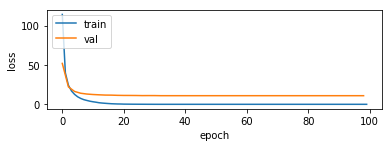

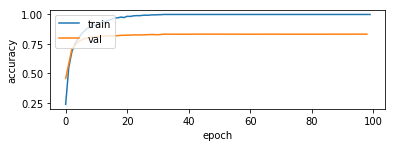

In [17]:
# NOTE THE CODE TEMPLATE BELOW WRAPS ALL OF THE ABOVE CODE, AND EXPOSES ONLY THE 
# DIFFERENT HYPERPARAMETER CHOICES. MAKE SURE YOU UNDERSTAND EXACTLY HOW
# THE ABOVE CODE WORKS FIRST. TO SAVE SOME SPACE, WE WILL COPY AND MODIFY THE 
# CODE BELOW TO BUILD AND TRAIN DIFFERENT MODELS IN THE REST OF THIS PRACTICAL. 
# YOU CAN USE WHICHEVER VERSION YOU PREFER FOR YOUR OWN EXPERIMENTS.

# Helper to wrap building, training, evaluating and plotting model accuracy.

def build_train_eval_and_plot(build_params, train_params, verbose=True):
    tf.reset_default_graph()
    m = DNNClassifier(**build_params)

    with tf.Session() as sess:
        # Train model on the MNIST dataset.
     
        train_losses, train_accs, val_losses, val_accs = train_tf_model(
                m, 
                sess,
                verbose=verbose,
                **train_params) 
        
        # Now evaluate it on the test set:
    
        accuracy_op = m.accuracy()    # Get the symbolic accuracy operation
        # Calculate the accuracy using the test images and labels.
        accuracy = accuracy_op.eval({m.x: mnist.test.images, 
                                                                 m.y: mnist.test.labels})    
        
        if verbose: 
            print("Accuracy on test set:", accuracy)
            # Plot losses and accuracies.
            plot_multi([train_losses, val_losses], ['train', 'val'], 'loss', 'epoch')
            plot_multi([train_accs, val_accs], ['train', 'val'], 'accuracy', 'epoch')
            
        
        ret = {'train_losses': train_losses, 'train_accs' : train_accs,
                     'val_losses' : val_losses, 'val_accs' : val_accs,
                     'test_acc' : accuracy}
        
        return m, ret

#################################CODE TEMPLATE##################################
# Specify the model hyperparameters (NOTE: All the defaults can be omitted):
model_params = {
        #'input_size' : 784,    # There are 28x28 = 784 pixels in MNIST images
        'hidden_sizes' : [512], # List of hidden layer dimensions, empty for linear model.
        #'output_size' : 10,    # There are 10 possible digit classes
        #'act_fn' : tf.nn.relu,    # The activation function to use in the hidden layers
        'l2_lambda' : 0.            # Strength of L2 regularization.
}

# Specify the training hyperparameters:
training_params = {'num_epochs' : 100,     # Max epochs/iterations to train for.
                        #'batch_size' : 100,    # Number of examples per batch, 100 default.
                        #'keep_prob' : 1.0,    # (1. - dropout) probability, none by default.
                        'train_only_on_fraction' : 5e-2,    # Fraction of training data to use, 1. for everything.
                        'optimizer_fn' : None,    # Optimizer, None for Adam.
                        'report_every' : 1, # Report training results every nr of epochs.
                        'eval_every' : 2,     # Evaluate on validation data every nr of epochs.
                        'stop_early' : False,    # Use early stopping or not.
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
        model_params, 
        training_params, 
        verbose=True    # Modify as desired.
)

###############################END CODE TEMPLATE################################

Above we plot the training loss vs the validation loss and the training accuracy vs the validation accuracy on only 5% (`train_only_on_fraction=5e-3`) of the training data (so that it doesn't take too long, and also so that our model can overfit easier). We see that the loss is coming down and the accuracies are going up, as expected! By training on a small subset of the training data, we established that 

* the data that the model is being trained on is hopefully not corrupt (this can happen during preprocessing, loading, etc), 
* our loss and gradients are likely correct, 
* our optimizer seems to do the right thing, 
* and generally, that our code probably works! 

**NOTE**: Notice the point where training loss/accuracy continues to improve, but validation accuracy starts to plateau? That is the point where the model starts to **overfit** the training data.


# Architectural Choices (15min)

## Depth

### A Linear 784-10 Model

Let's evaluate the simple linear model trained on the full dataset and then add layers to see what effect this will have on the accuracy.

**NOTE**: If you're unsure what the "784-10" notation means, scroll up and re-read the section on "Building a Feed-forward Neural Network" where we explain that.

Epoch: 0001 Training cost= 3.979346356
Epoch: 0001 Validation acc= 0.720000029
Epoch: 0002 Training cost= 1.173970768
Epoch: 0002 Validation acc= 0.819400012
Epoch: 0003 Training cost= 0.831302601
Epoch: 0003 Validation acc= 0.857200027
Epoch: 0004 Training cost= 0.684144043
Epoch: 0004 Validation acc= 0.870599985
Epoch: 0005 Training cost= 0.600522155
Epoch: 0005 Validation acc= 0.877399981
Epoch: 0006 Training cost= 0.544605434
Epoch: 0006 Validation acc= 0.886200011
Epoch: 0007 Training cost= 0.503139624
Epoch: 0007 Validation acc= 0.890999973
Epoch: 0008 Training cost= 0.472414856
Epoch: 0008 Validation acc= 0.896399975
Epoch: 0009 Training cost= 0.447278972
Epoch: 0009 Validation acc= 0.898800015
Epoch: 0010 Training cost= 0.426831512
Epoch: 0010 Validation acc= 0.900399983
Epoch: 0011 Training cost= 0.409658925
Epoch: 0011 Validation acc= 0.902800024
Epoch: 0012 Training cost= 0.394903696
Epoch: 0012 Validation acc= 0.903800011
Epoch: 0013 Training cost= 0.382545183
Epoch: 0013 V

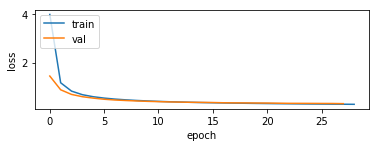

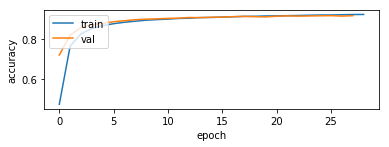

CPU times: user 32.6 s, sys: 6.22 s, total: 38.8 s
Wall time: 25.5 s


In [18]:
%%time
# Train the linear model on the full dataset.

################################################################################
# Specify the model hyperparameters.
model_params = {'l2_lambda' : 0.}

# Specify the training hyperparameters:
training_params = {'num_epochs' : 50,     # Max epochs/iterations to train for.
                   'optimizer_fn' : None,            # Now we're using Adam.
                   'report_every' : 1, # Report training results every nr of epochs.
                   'eval_every' : 1,     # Evaluate on validation data every nr of epochs.
                   'stop_early' : True    
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
        model_params, 
        training_params, 
        verbose=True    # Modify as desired.
)

################################################################################

~91% is quite a bad score on MNIST! Now let's build a deeper model, to improve on that score. 

### 1 hidden layer: 784-512-10 Architecture w/ L2

Notice that we add a bit of L2-regularization to our model.

**QUESTION**: What does that do? What is the effect of removing it? Try it!

Epoch: 0001 Training cost= 176.821376273
Epoch: 0001 Validation acc= 0.891799986
Epoch: 0002 Training cost= 114.372428880
Epoch: 0002 Validation acc= 0.920599997
Epoch: 0003 Training cost= 86.876626823
Epoch: 0003 Validation acc= 0.929600000
Epoch: 0004 Training cost= 68.870978199
Epoch: 0004 Validation acc= 0.935000002
Epoch: 0005 Training cost= 55.311025092
Epoch: 0005 Validation acc= 0.940400004
Epoch: 0006 Training cost= 44.503921481
Epoch: 0006 Validation acc= 0.946200013
Epoch: 0007 Training cost= 35.763617710
Epoch: 0007 Validation acc= 0.945999980
Epoch: 0008 Training cost= 28.700154362
Epoch: 0008 Validation acc= 0.950399995
Epoch: 0009 Training cost= 23.008252097
Epoch: 0009 Validation acc= 0.950600028
Epoch: 0010 Training cost= 18.392711143
Epoch: 0010 Validation acc= 0.943000019
Epoch: 0011 Training cost= 14.682333702
Epoch: 0011 Validation acc= 0.948199987
Epoch: 0012 Training cost= 11.746643137
Epoch: 0012 Validation acc= 0.952600002
Epoch: 0013 Training cost= 9.370329402

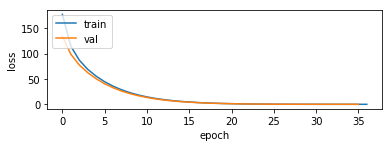

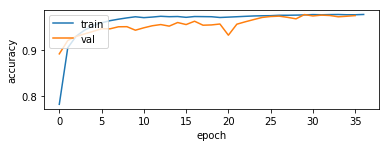

CPU times: user 6min 45s, sys: 31 s, total: 7min 16s
Wall time: 1min 37s


In [17]:
%%time
    
# Specify the model hyperparameters (NOTE: All the defaults can be omitted):
model_params = {
        'hidden_sizes' : [512],    # List of hidden layer dimensions, empty for linear model.
        'l2_lambda' : 1e-3            # Strength of L2 regularization.
}

# Specify the training hyperparameters:
training_params = {
        'num_epochs' : 50,        # Max epochs/iterations to train for.
        'report_every' : 1,     # Report training results every nr of epochs.
        'eval_every' : 1,         # Evaluate on validation data every nr of epochs.
        'stop_early' : True    # Use early stopping or not.
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
        model_params, 
        training_params, 
        verbose=True    # Modify as desired.
)

**97.7%** is a much more decent score! The 1 hidden layer model gives a much better score than the linear model, so let's see if we can do better by adding another layer!

### Going deeper! A 784-512-512-10 architecture w/ L2

Epoch: 0001 Training cost= 482.650715942
Epoch: 0001 Validation acc= 0.915400028
Epoch: 0002 Training cost= 324.735924294
Epoch: 0002 Validation acc= 0.939000010
Epoch: 0003 Training cost= 289.963919178
Epoch: 0003 Validation acc= 0.943000019
Epoch: 0004 Training cost= 267.174931724
Epoch: 0004 Validation acc= 0.953800023
Epoch: 0005 Training cost= 248.735115093
Epoch: 0005 Validation acc= 0.955399990
Epoch: 0006 Training cost= 233.206841500
Epoch: 0006 Validation acc= 0.960799992
Epoch: 0007 Training cost= 219.021586470
Epoch: 0007 Validation acc= 0.950999975
Epoch: 0008 Training cost= 206.817723680
Epoch: 0008 Validation acc= 0.959399998
Epoch: 0009 Training cost= 195.015378168
Epoch: 0009 Validation acc= 0.964999974
Epoch: 0010 Training cost= 184.170884497
Epoch: 0010 Validation acc= 0.959999979
Epoch: 0011 Training cost= 173.968027385
Epoch: 0011 Validation acc= 0.964200020
Epoch: 0012 Training cost= 164.182535137
Epoch: 0012 Validation acc= 0.966199994
Epoch: 0013 Training cost= 1

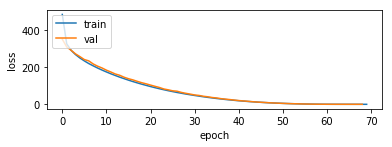

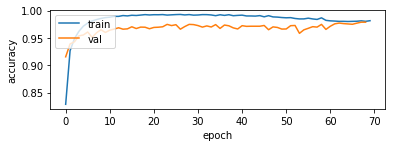

CPU times: user 27min 4s, sys: 1min 33s, total: 28min 37s
Wall time: 5min 17s


In [18]:
%%time 

# Specify the model hyperparameters (NOTE: All the defaults can be omitted):
model_params = {
        'hidden_sizes' : [512, 512], # List of hidden layer dimensions, empty for linear model.
        'l2_lambda' : 1e-3                     # Strength of L2 regularization.
}

# Specify the training hyperparameters:
training_params = {
        'num_epochs' : 200,     # Max epochs/iterations to train for.
        'report_every' : 1,     # Report training results every nr of epochs.
        'eval_every' : 1,         # Evaluate on validation data every nr of epochs.
        'stop_early' : True,    # Use early stopping or not.
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
        model_params, 
        training_params, 
        verbose=True    # Modify as desired.
)

    

You should get around **97.4**%. Shouldn't deeper do better?! Why is it that the 2-hidden layer model

* ***took much longer to train*** (2min 46s versus 1min 3s on our system), and
* ***got roughly the same accuracy*** as the 1 hidden layer model (sometimes worse)?

This illustrates the **fundamental difficulty of training deep networks** that have plagued deep learning research for decades (and to some extent, still do): 

> ***Although deeper networks can give you more powerful models, training those models to find the right parameters is not always easy & takes a lot of computing power (time)!***

For a long time people just believed it wouldn't work because a) fewer people tried to make it work, and those who did b) didn't have enough data or computing power to really explore the vast space of hyperparameters. These days, we have more data and more compute power, however one can never have 'enough' resources :) This is where the art of doing proper hyper-parameter selection comes in. In fact, we should be able to squeeze out another percentage point or so by choosing better:

* Optimizer + its hyperparams (learning rate, momentum rates, etc)
* batch-size,
* choice of regularization.

For a new problem, we will typically spend most of our time exploring these choices, usually just by launching many different training runs (hopefully in parallel and using GPUs!) and keeping the best ones.


# EXTRA: How to Choose Architectures?

How does one design new architectures? Should you use:

* a tapered architecture (large-medium-small),
* a "regular" (like the Levi's :) architecture (large-med-med-...-small),
* a "bottlenecked" architecutre (large-small-large)?
* an "over-complete" architecture (small-large-small). 

Unfortunately it mostly comes down to just developing your own intuition over time, and trying different approaches in hyperparameter search. 

However, a good pattern to follow in general is something like the following:

1. Start with a basic architecture and overfit a portion of your training data.
2. As you train on more data, add capacity and prevent overfitting by
    * Adding more units to the hidden layer (often times wide still beats deep)
    * Add one or two more hidden layers, trying some architectural choices mentioned above.
    * Add dropout.
    
The goal is to match your architecture to your data, meaning you have just enough capacity to fit the data, but not too much to easily overfit. The easiest way to do this is to gradually build up the capacity of your model in this way.

# EXTRA: Hyperparameter Selection (USE A GPU INSTANCE FOR THIS)

## Random grid-search

Most of the deep learning practitioner's time will be spent training and evaluating new model architectures with different hyperparameter combinations.    General rules of thumb exist, but often times change for each new architecture or dataset. Several approaches exist for automatic hyperparameter selection (grid search, random search, Bayesian methods). In practice, most people just use a **randomized grid-search** approach to try out different hyperparams, where one defines sensible values for each hyperparameter, and then randomly samples from the (cross-product space) of all of these possible combinations. This space grows exponentially, making exhaustive search infeasible for all but the simplest models. In practice, randomized search have also been found to find the best values, quicker (see [Bergstra and Bengio 2009](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) if you're interested in the details).

Below, we will illustrate the basic idea with a skeleton randomized grid search implementation. In practice, one would launch these different runs in parallel on a computing cluster, making it easier to explore multiple options at the same time. Here, we would just try out a few different options to get a sense for how that would work. 

**NOTE**: We will keep the models small here (so we won't get SOTA results), in order to keep the training times reasonable, but to illustrate how dependent results are on these choices.

**Architecture Selection**: Let's consider 1 and 2-hidden layer models. For each layer, we'll try out [128, 256] neurons per layer. We'll stick to ReLUs for this.

**Hyperparameters**: Let's pick SGD with Momentum as our optimizer (a good, stable workhorse), with a fixed computational budget of 20 training epochs. We'll need to pick ranges for the following:
* *learning rate*: we'll use a log-scale from 1e-5 to 1.
* *momentum coefficient*: we'll use a log-scale from 5e-1 (0.5) to 1.
* *L2 regularization*: we'll use a log-scale from 1e-5 to 1.


In [19]:
def sample_log_scale(v_min=1e-6, v_max=1.):
    '''Sample uniformly on a log-scale from 10**v_min to 10**v_max.'''
    return np.exp(np.random.uniform(np.log(v_min), np.log(v_max)))


def sample_model_architecture_and_hyperparams(max_num_layers=2,
                                              lr_min=1e-6,
                                              lr_max=1.,
                                              mom_min=0.5,
                                              mom_max=1.,
                                              l2_min=1e-4,
                                              l2_max=1.):
        '''Generate a random model architecture & hyperparameters.'''
        
        # Sample the architecture.
        num_layers = np.random.choice(range(1, max_num_layers+1))
        hidden_sizes = []
        layer_ranges=[128, 256]
        for l in range(num_layers):
            hidden_sizes.append(np.random.choice(layer_ranges))
        
        # Sample the training parameters.
        l2_lambda = sample_log_scale(l2_min, l2_max)
        lr = sample_log_scale(lr_min, lr_max)
        mom_coeff = sample_log_scale(mom_min, mom_max)
        
        # Build base model definitions:
        model_params = {
                'hidden_sizes' : hidden_sizes,
                'l2_lambda' : l2_lambda}

        # Specify the training hyperparameters:
        training_params = {
                'num_epochs' : 20,
                'optimizer_fn' : tf.train.MomentumOptimizer(
                        learning_rate=lr, 
                        momentum=mom_coeff),
                'report_every' : 1,
                'eval_every' : 1,
                'stop_early' : True}
        
        return model_params, training_params

# TEST THIS: Run this cell a few times and look at the different outputs. 
# Each of these will be a different model trained with different hyperparameters.
m, t = sample_model_architecture_and_hyperparams()
print(m)
print(t)


{'hidden_sizes': [128, 128], 'l2_lambda': 0.006400327800616545}
{'num_epochs': 20, 'optimizer_fn': <tensorflow.python.training.momentum.MomentumOptimizer object at 0x124cea550>, 'report_every': 1, 'eval_every': 1, 'stop_early': True}


We will play around with the strength of the L2 regularization. Let's use SGD+Momentum, and run for a fixed budget of 20 epochs:

In [20]:
results = []

# Perform a random search over hyper-parameter space this many times.
NUM_EXPERIMENTS = 10

for i in range(NUM_EXPERIMENTS): 
    
    # Sample the model and hyperparams we are using.
    model_params, training_params = sample_model_architecture_and_hyperparams()
    
    print("RUN: %d out of %d:" % (i, NUM_EXPERIMENTS))
    print("Sampled Architecture: \n", model_params)
    print("Hyper-parameters:\n", training_params)
    
    # Build, train, evaluate
    model, performance = build_train_eval_and_plot(
            model_params, training_params, verbose=False)
    
    # Save results
    results.append((performance['test_acc'], model_params, training_params))
    
# Display (best?) results/variance/etc:
results.sort(key=lambda x : x[0], reverse=True)

RUN: 0 out of 10:
Sampled Architecture: 
 {'hidden_sizes': [256], 'l2_lambda': 0.000285562584266694}
Hyper-parameters:
 {'num_epochs': 20, 'optimizer_fn': <tensorflow.python.training.momentum.MomentumOptimizer object at 0x118ad2198>, 'report_every': 1, 'eval_every': 1, 'stop_early': True}
Optimization Finished!
RUN: 1 out of 10:
Sampled Architecture: 
 {'hidden_sizes': [256, 256], 'l2_lambda': 0.006766549378200129}
Hyper-parameters:
 {'num_epochs': 20, 'optimizer_fn': <tensorflow.python.training.momentum.MomentumOptimizer object at 0x1231bbe48>, 'report_every': 1, 'eval_every': 1, 'stop_early': True}
Optimization Finished!
RUN: 2 out of 10:
Sampled Architecture: 
 {'hidden_sizes': [256], 'l2_lambda': 0.009249847342616226}
Hyper-parameters:
 {'num_epochs': 20, 'optimizer_fn': <tensorflow.python.training.momentum.MomentumOptimizer object at 0x118ad2b38>, 'report_every': 1, 'eval_every': 1, 'stop_early': True}
Validation loss stopped improving, stopping training early after 4 epochs!
Opti

In [21]:
for r in results:
    print(r)    # Tuples of (test_accuracy, model_hyperparameters, training_hyperparameters)

(0.96, {'hidden_sizes': [256, 256], 'l2_lambda': 0.006766549378200129}, {'num_epochs': 20, 'optimizer_fn': <tensorflow.python.training.momentum.MomentumOptimizer object at 0x1231bbe48>, 'report_every': 1, 'eval_every': 1, 'stop_early': True})
(0.9569, {'hidden_sizes': [128], 'l2_lambda': 0.004737378064547783}, {'num_epochs': 20, 'optimizer_fn': <tensorflow.python.training.momentum.MomentumOptimizer object at 0x118cefa90>, 'report_every': 1, 'eval_every': 1, 'stop_early': True})
(0.9312, {'hidden_sizes': [256], 'l2_lambda': 0.000285562584266694}, {'num_epochs': 20, 'optimizer_fn': <tensorflow.python.training.momentum.MomentumOptimizer object at 0x118ad2198>, 'report_every': 1, 'eval_every': 1, 'stop_early': True})
(0.923, {'hidden_sizes': [256], 'l2_lambda': 0.009249847342616226}, {'num_epochs': 20, 'optimizer_fn': <tensorflow.python.training.momentum.MomentumOptimizer object at 0x118ad2b38>, 'report_every': 1, 'eval_every': 1, 'stop_early': True})
(0.8683, {'hidden_sizes': [128], 'l2_l

**Notice the huuuuge variance in the test accuracies!** This is just a toy run, but hopefully it illustrates how important choosing the right architectures and training hyperparameters is to getting good results in deep learning.

Below, we've included some hyperparameter settings which achieve near state-of-the-art results.

# EXTRA: Known Good Models

## 784-500-300-10 w/ L2 + SGD + Momentum

**Best so far: 98.02% test accuracy when we ran this (well, in one of our training runs :).**

Epoch: 0001 Training cost= 299.901663624
Epoch: 0001 Validation acc= 0.184000000
Epoch: 0002 Training cost= 218.648436834
Epoch: 0002 Validation acc= 0.189799994
Epoch: 0003 Training cost= 175.570795288
Epoch: 0003 Validation acc= 0.339800000
Epoch: 0004 Training cost= 140.954676854
Epoch: 0004 Validation acc= 0.347799987
Epoch: 0005 Training cost= 113.180692430
Epoch: 0005 Validation acc= 0.446000010
Epoch: 0006 Training cost= 90.909929643
Epoch: 0006 Validation acc= 0.504599988
Epoch: 0007 Training cost= 72.807562984
Epoch: 0007 Validation acc= 0.660600007
Epoch: 0008 Training cost= 58.235078888
Epoch: 0008 Validation acc= 0.772800028
Epoch: 0009 Training cost= 46.594354449
Epoch: 0009 Validation acc= 0.871200025
Epoch: 0010 Training cost= 37.300518043
Epoch: 0010 Validation acc= 0.920599997
Epoch: 0011 Training cost= 29.883832814
Epoch: 0011 Validation acc= 0.931200027
Epoch: 0012 Training cost= 23.942953207
Epoch: 0012 Validation acc= 0.940599978
Epoch: 0013 Training cost= 19.20103

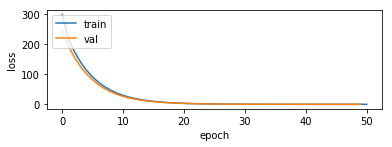

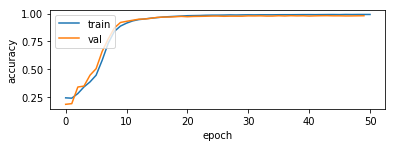

CPU times: user 12min 28s, sys: 57.4 s, total: 13min 25s
Wall time: 2min 43s


In [22]:
%%time 

# Specify the model hyperparameters (NOTE: All the defaults can be omitted):
model_params = {
        'hidden_sizes' : [500, 300], # List of hidden layer dimensions, empty for linear model.
        'l2_lambda' : 1e-3                     # Strength of L2 regularization.
}

# Specify the training hyperparameters:
training_params = {'num_epochs' : 100,     # Max epochs/iterations to train for.
                        'optimizer_fn' : tf.train.MomentumOptimizer(learning_rate=2e-3, momentum=0.98),
                        'report_every' : 1, # Report training results every nr of epochs.
                        'eval_every' : 1,     # Evaluate on validation data every nr of epochs.
                        'stop_early' : True,    # Use early stopping or not.
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
        model_params, 
        training_params, 
        verbose=True    # Modify as desired.
)

# NB: Before you go (5min)

Pair up with someone else and go through the questions in "Learning Objectives" at the top. Take turns explaining each of these to each other, and be sure to ask the tutors if you're both unsure!

# Additional Resources



* TensorFlow Debugging (useful tips and code patterns): https://github.com/wookayin/tensorflow-talk-debugging


# Feedback

Please send any bugs and comments to dli-practicals@googlegroups.com.